In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jj

### Connecting Neurons
The next step in creating a Spiking Neural Network is to be able to connect two neurons together. If we connect the neurons as presented in the [circuit](https://github.com/ubsuny/Josephson_Junction_Neuromorphic-Raspi4-/blob/87b64adf961712c6d819b1c553c51c26f8a4b849/Circuit.png) discussed. According to the paper by Crotty$^{[2]}$, the connection between the neurons can be defined by a set of coupled differential equations:
$\frac{1}{\Omega_0^2}\ddot{v}_{out}+\frac{Q}{\Omega_0}\dot{v}_{out}+v_{out}=v_p-\frac{Q \Omega_0 \Lambda_{syn}}{\lambda}i_{12} - \frac{\Lambda_{syn}}{lambda}\dot{i}_{12}$  

$\frac{\Lambda_{syn}(1-\Lambda_{syn})}{\lambda}\dot{i}_{12}+\frac{r_{12}}{\Gamma}i_{12}=v_{out}-\Lambda_{syn}(v_{c2}+v_{p2})$  

$\Omega_0 = 1.0, Q = 0.05, \Lambda_{syn} = 0.3, r_{12} = 1.4$, other parameters are the same, save for $i_b = 2.0, \Gamma = 2.0$


This gives both the output voltage and the input voltage based on the output voltage. This means it is now possible to adjust the input current to the neuron based on the voltage output.

In [2]:
## Time domain set up
time = 10000 # Final Time
n = time/0.05 # Resolution

#time = 300 # Final Time
#n = 20000 # Resolution

dt = time / n # A single time step length
tspan = np.arange(0, time, dt)  # time span
ispan = np.zeros((2,np.size(tspan)))  # input current span

## System Parameters
lmda = 0.1
gamma = 2.0
lmda_s = 0.5
lmda_p = 0.5
eta = 1
i_in = 0.3
i_b = 2.0

## Weight Parameters
w = 1
dw = 0
threshold = 0.3

A = 0.1 # Additive learning rate
B = 0.1 # Reductive learning rate
tau = 20 # Timescale of learning

## Synapse parameters
Q = 0.05
lmda_syn = 0.3
r12 = 1.4
omega = 1.0


## First Neuron Input Layer
neuron1 = np.zeros((2,2,2,np.size(tspan))) # 2 neurons, pulse and control channel, phase and current, as long as t
ii1 = np.zeros((2,2)) # 2 neurons, 2 input currents

flux1 = np.zeros((2,np.size(tspan))) # 2 neurons, 1 flux, as long as t

io1 = np.zeros((2,4,4)) # 2 neuron output currents connect to 4 neurons with four param i, di, v, and dv


## First set of weights
to1 = np.zeros((2,)) # original time of spike for 2 neurons
#w1 = np.ones((2,4)) # 2 neurons, connected to four separate neurons
w1 = 2*np.random.rand(2,4)-1
tf1 = np.zeros((4,)) # final time of spike for the 4 neurons
last_fire1 = np.zeros((2,4))


## Second Neuron Hidden Layer
neuron2 = np.zeros((4,2,2,np.size(tspan))) # 4 neurons, 2 channels, as long as t
ii2 = np.zeros((4,2)) # 4 neurons, 4 input currents

flux2 = np.zeros((4,np.size(tspan))) # 4 neurons, 1 flux, as long as t

io2 = np.zeros((4,1,4)) # 4 neuron output currents connect to 1 with four param i, di, v, and dv


## Second set of weights
to2 = np.zeros((4,))
#w2 = np.ones((4,1)) # 4 neurons, connected to a single neuron
w2 = 2*np.random.rand(4,1)-1
tf2 = np.zeros((1,))
last_fire2 = np.zeros((1,4))

## Third Neuron Output Layer

neuron3 = np.zeros((1,2,2,np.size(tspan))) # 1 neurons, 2 channels, as long as t
ii3 = np.zeros((1,2)) # 1 neurons, 2 input currents

flux3 = np.zeros((1,np.size(tspan))) # 1 neurons, 1 flux, as long as t


## Define training current
ispan[0,0:int(np.size(ispan[0,:])/3)] = i_in
ispan[1,int(np.size(ispan[0,:])/3):2*int(np.size(ispan[0,:])/3)] = i_in

## Define testing current
times = np.array([[350,367,384],[401,418,435],[452,469,486]])
p = int(np.size(ispan[0,:])/500)
ps = p*times
pf = p*(times+1)
for i in [0,1,2]:
    ispan[0,ps[0,i]:pf[0,i]] = i_in # Check for 1,0
    ispan[1,ps[1,i]:pf[1,i]] = i_in # Check for 0,1
    ispan[:,ps[2,i]:pf[2,i]] = i_in # Check for 1,1

In [3]:
## Initial Conditions, Nueron 1

# Most IC's are 0, so I will not include the code for sake of time, but it can be added by slicing neuron1

ii1[:,0] = -lmda*(neuron1[:,1,0,0] + neuron1[:,0,0,0]) + lmda_s*ispan[:,0] + (1-lmda_p)*i_b
ii1[:,1] = (-lmda*(neuron1[:,1,0,0] + neuron1[:,0,0,0]) + lmda_s*ispan[:,0] - lmda_p*i_b)/eta

## Initial Conditions, Synapse

# Same as above

## Initial Conditions, Neuron 2

# Same as above

ii2[:,0] = -lmda*(neuron2[:,1,0,0] + neuron2[:,0,0,0]) + lmda_s*0 + (1-lmda_p)*i_b
ii2[:,1] = (-lmda*(neuron2[:,1,0,0] + neuron2[:,0,0,0]) + lmda_s*0 - lmda_p*i_b)/eta

## Initial Conditions, Neuron 3

ii3[:,0] = -lmda*(neuron3[:,1,0,0] + neuron3[:,0,0,0]) + lmda_s*0 + (1-lmda_p)*i_b
ii3[:,1] = (-lmda*(neuron3[:,1,0,0] + neuron3[:,0,0,0]) + lmda_s*0 - lmda_p*i_b)/eta

In [4]:
oc = [0]  # Output Current to plot later
wspan = [1]
## Operate the Circuit
for j in range(np.size(tspan)-1):
    ## First Neuron
    for i in [0,1]:
        neuron1[i,0,:,j+1] = jj.junction_step(neuron1[i,0,0,j],neuron1[i,0,1,j],dt,gamma,ii1[i,0])
        neuron1[i,1,:,j+1] = jj.junction_step(neuron1[i,1,0,j],neuron1[i,1,1,j],dt,gamma,ii1[i,1])
        ii1[i,:] = jj.currents(lmda,neuron1[i,0,0,j+1],neuron1[i,1,0,j+1],lmda_s,ispan[i,j+1],lmda_p,i_b,eta)
        flux1[i,j+1] = lmda*(neuron1[i,0,0,j+1] + neuron1[i,1,0,j+1])

    
        ## Check weights
        if (flux1[i,j-1] < flux1[i,j] > flux1[i,j+1] and flux1[i,j] > threshold):
            to1[i] = tspan[j]
            for ii in [0,3]:    
                if last_fire1[i,ii] == 1:
                    w1[i,ii] = w1[i,ii] + jj.change_weights(A,B,tau,tf1[ii],to1[i])
                    last_fire1[i,ii] = 0
    
    ## Output to Second Neuron
        for ii in [0,1,2,3]:
            io1[i,ii,:] = jj.synapse_step(io1[i,ii,0], io1[i,ii,1], io1[i,ii,2], io1[i,ii,3],
                                          neuron1[i,0,1,j], neuron2[ii,0,1,j], neuron2[ii,1,1,j], 
                                          gamma, omega, Q, lmda, lmda_syn, r12, dt)
   
    #oc.append(w*i_o)
    
    ## Second Neuron
    for i in [0,1,2,3]:
        current1 = np.sum(w1[:,i]*io1[:,i,2])
        neuron2[i,0,:,j+1] = jj.junction_step(neuron2[i,0,0,j],neuron2[i,0,1,j],dt,gamma,ii2[i,0])
        neuron2[i,1,:,j+1] = jj.junction_step(neuron2[i,1,0,j],neuron2[i,1,1,j],dt,gamma,ii2[i,1])
        ii2[i,:] = jj.currents(lmda,neuron2[i,0,0,j+1],neuron2[i,1,0,j+1],lmda_s,current1,lmda_p,i_b,eta)
        flux2[i,j+1] = lmda*(neuron2[i,0,0,j+1] + neuron2[i,1,0,j+1])
        
        ## Check weights 1
        if (flux2[i,j-1] < flux2[i,j] > flux2[i,j+1] and flux2[i,j] > threshold):
            tf1[i] = tspan[j]
            for ii in [0,1]:    
                if last_fire1[ii,i] == 0:
                    w1[ii,i] = w1[ii,i] + jj.change_weights(A,B,tau,tf1[i],to1[ii])
                    last_fire1[ii,i] = 1
                    
        ## Check weights 2
        if (flux2[i,j-1] < flux2[i,j] > flux2[i,j+1] and flux2[i,j] > threshold):
            to2[i] = tspan[j]  
            if last_fire2[0,i] == 1:
                w2[i,0] = w2[i] + jj.change_weights(A,B,tau,tf2[0],to2[i])
                last_fire2[0,i] = 0
                    
    ## Output to Third neuron
        io2[i,0,:] = jj.synapse_step(io2[i,0,0], io2[i,0,2], io2[i,0,2], io2[i,0,3],
                                      neuron2[i,0,1,j], neuron3[0,0,1,j], neuron3[0,1,1,j], 
                                      gamma, omega, Q, lmda, lmda_syn, r12, dt)
    ## Third Neuron
    current2 = np.sum(w2*io2[:,0,2])
    neuron3[0,0,:,j+1] = jj.junction_step(neuron3[0,0,0,j],neuron3[0,0,1,j],dt,gamma,ii3[0,0])
    neuron3[0,1,:,j+1] = jj.junction_step(neuron3[0,1,0,j],neuron3[0,1,1,j],dt,gamma,ii3[0,1])
    ii3[0,:] = jj.currents(lmda,neuron3[0,0,0,j+1],neuron3[0,1,0,j+1],lmda_s,current1,lmda_p,i_b,eta)
    flux3[0,j+1] = lmda*(neuron3[0,0,0,j+1] + neuron3[0,1,0,j+1])
    
    ## Check weights 2
    if (flux3[0,j-1] < flux3[0,j] > flux3[0,j+1] and flux3[0,j] > threshold):
        tf2[0] = tspan[j]
        for ii in [0,1,2,3]:    
            if last_fire2[0,ii] == 0:
                w2[ii,0] = w2[ii,0] + jj.change_weights(A,B,tau,tf2[0],to2[ii])
                last_fire2[0,ii] = 1

/home/pi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:66: RuntimeWarning: overflow encountered in double_scalars
  - lmda_syn/lmda * id_0 - v_0 - Q/omega * vd_0)*dt
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:64: RuntimeWarning: overflow encountered in double_scalars
  v = v_0 + vd_0 * dt
/home/pi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:66: RuntimeWarning: invalid value encountered in double_scalars

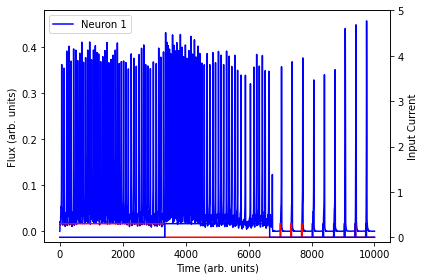

In [5]:
## Plotting
fig, ax1 = plt.subplots()

fig.patch.set_facecolor('white')

ax1.set_xlabel('Time (arb. units)')
ax1.set_ylabel('Flux (arb. units)')
ax1.plot(tspan,flux3[0], 'b')

# ax1.set_xlim(0,250)
# ax1.set_ylim(-0.1,0.6)
ax1.legend(["Neuron 1","Neuron 2"],loc='upper left')

ax2 = ax1.twinx()
ax2.plot(tspan,ispan[0,:], 'r')
ax2.plot(tspan,ispan[1,:], 'b-')
ax2.set_ylim(-0.1,5)
ax2.set_ylabel('Input Current')

fig.tight_layout()
plt.show()

Here we can see the one neuron driving the other neuron based of of an input current. When the current drops to 0, there is no firing of either neuron. Given that we can calculate the potential and current from the output of a neuron, we can start to consider making a network of these connections.